In [111]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import matplotlib
# matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import numpy as np
from pathlib import Path
import time


from tqdm.autonotebook import tqdm
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
!grep -n skip_slim_inp ~/models/tx/pix2pix/*/runs.txt 

/nfs/home/anerinovsky/models/tx/pix2pix/skip-modulate-cont/runs.txt:33:EXP_NAME=skip-modulate-cont
/nfs/home/anerinovsky/models/tx/pix2pix/skip-modulate-cont/runs.txt:90:EXP_NAME=skip-modulate-cont
/nfs/home/anerinovsky/models/tx/pix2pix/skip-modulate/runs.txt:33:EXP_NAME=skip-modulate
/nfs/home/anerinovsky/models/tx/pix2pix/skip-modulate/runs.txt:89:EXP_NAME=skip-modulate


In [125]:
!head ~/models/tx/pix2pix/skip-modulate/runs.txt 

skip
Вт янв 21 18:08:04 MSK 2020

LC_PAPER=ru_RU.UTF-8
XDG_SESSION_ID=5
LC_ADDRESS=ru_RU.UTF-8
LC_MONETARY=ru_RU.UTF-8
IPPROOT=/nfs/home/anerinovsky/intel/compilers_and_libraries_2018.3.222/linux/
TERM=screen
SHELL=/bin/bash


In [135]:
!head ~/models/tx/pix2pix/inpaint-losses/runs.txt 

inpaint
Сб янв  4 13:26:16 MSK 2020

LC_PAPER=ru_RU.UTF-8
XDG_SESSION_ID=6
LC_ADDRESS=ru_RU.UTF-8
LC_MONETARY=ru_RU.UTF-8
IPPROOT=/nfs/home/anerinovsky/intel/compilers_and_libraries_2018.3.222/linux/
TERM=screen
SHELL=/bin/bash


In [112]:
def load_loss_log(run):
    
    file = Path(f'~/models/tx/pix2pix/{run}/loss_log.txt').expanduser()
    if not file.exists():
        return None, None, None
    
    lines = file.read_text().split('\n')
    lines = [ line[1:].replace(')', '').replace(',', '').replace(':', '').split() for line in lines if line and line[0] == '('  ]
    lines = [ dict(zip(line[::2],map(float, line[1::2]))) for line in lines ]
        
    net_cfg = Path(f'~/models/tx/pix2pix/{run}/runs.txt').expanduser()
    net_cfg = net_cfg.read_text().split('\n')[0] if net_cfg.exists() else None
    
    return pd.DataFrame(lines), file.stat().st_mtime, net_cfg

def _create_runs_dfs(runs):
    
    runs_dfs = {}

    for run in tqdm(runs):
        run_df, mtime, net_cfg = load_loss_log(run)

        if run_df is not None:
            runs_dfs[run] = run_df, mtime, net_cfg
        else:
            print('Failed on', run)
        
    return runs_dfs
            
def _print_runs_dfs(runs_dfs):
    
    for run, (df, mtime, net_cfg) in sorted(runs_dfs.items(), key=lambda x: x[1][1]):
        args = ()
        if 'G_L1' in df.columns:
            args += ( f'min G_L1 {df.G_L1.min():6} ', )
        if net_cfg is not None:
            args += ( 'net_cfg', net_cfg)

        time_str = time.ctime(mtime)
        print(time_str, f'| {run[:20]:20} | {len(df):6}',  *args)
        if run[20:]:
            print(' ' * len(time_str), f'| {run[20:]:>20} |')
            
def _runs_dfs_to_df(runs_dfs):
    _df = []

    for run, (df, mtime, net_cfg) in sorted(runs_dfs.items(), key=lambda x: x[1][1]):
        if 'G_L1' in df.columns:
            df['run'] = run
            df['mtime'] = time.ctime(mtime)
            df['net_cfg'] = net_cfg
            _df.append(df)

    df = pd.concat(_df).reset_index()
    return df

def load_df(verbose=True):
    runs = !ls ~/models/tx/pix2pix/
    print('Creatig runs_dfs')
    runs_dfs = _create_runs_dfs(runs)
    if verbose:
        _print_runs_dfs(runs_dfs)
        
    print('Creating df')
    df = _runs_dfs_to_df(runs_dfs)
    return df


In [147]:
df = load_df() 

Creatig runs_dfs



Mon Dec  2 02:32:37 2019 | bigger-net           |    917 min G_L1   4.35 
Mon Dec  2 02:33:25 2019 | test_tx              |   1467 min G_L1   0.59 
Thu Dec  5 19:35:21 2019 | test                 |      8 min G_L1 23.692 
Fri Dec  6 21:04:01 2019 | test_run             |      0
Tue Dec 10 17:08:36 2019 | tv-and-masks         |   2241
Tue Dec 10 18:13:14 2019 | tx-mask              |      0
Tue Dec 10 18:35:49 2019 | test-cond            |      1 min G_L1 39.956 
Tue Dec 10 19:54:02 2019 | long-one             |   3015 min G_L1  3.675 
Tue Dec 10 20:01:38 2019 | cond-norm            |      9 min G_L1 16.121 
Thu Dec 12 10:34:49 2019 | new-losses           |    771
Tue Dec 17 03:00:10 2019 | cond                 |   6402 min G_L1  2.571 
Fri Dec 20 14:05:47 2019 | cond-ds-v2           |   4742 min G_L1  1.801 
Sat Dec 21 15:46:02 2019 | cond_style           |   2002 min G_L1  2.468 
Sun Dec 22 03:50:01 2019 | cond_less_style      |   1032 min G_L1  3.453 
Sun Dec 22 20:34:29 2019 | test

/media/disk1/anerinovsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [133]:
def _normalize_ep_size(df, ep_size):
    if ep_size == 'auto':
        ep_size = df.iters.max() - df.iters.min()
        print('setting ep_size to ', ep_size)
    elif ep_size == 'big':
        ep_size = 245225
        print('setting ep_size to ', ep_size)
    else:
        assert isinstance(ep_size, int)
        
    return ep_size
    
def _L1_xs(df, avg_step=50, mode='auto', ep_size='auto'):
    
    ep_size = _normalize_ep_size(df, ep_size)
    
    if mode == 'auto':
        xs = df.iters + (df.epoch - 1)*ep_size
    elif mode == 'fixed':
        xs = np.arange(0, len(df))
    else:
        assert False, f'No mode {mode} exists'
    
    xs = (xs // avg_step) * avg_step
    
    return xs

def _plot_L1(_df, ax, **kw):
    
    xs = _L1_xs(_df, 
                    avg_step=kw.pop('avg_step', 1000), 
                    ep_size=kw.pop('ep_size', 'auto'))
    ys = _df.G_L1
    
    if kw.pop('no_ci', True):
        kw['ci'] = None
    
       
    
    sns.lineplot(x=xs, y=ys, estimator='mean', ax=ax, **kw)
    
def _ep_ticks(df, ep_size='auto'):    
    
    ep_size = _normalize_ep_size(df, ep_size)
    
    ticks, labels = zip(*( (int(ep_size*ep), ep) for ep in range(int(_df.epoch.max())) ))
    plt.xticks(ticks, labels)
    
    
def _plot_D(_df, ax, **kw):
    
    xs = _L1_xs(_df, 
                    avg_step=kw.pop('avg_step', 1000), 
                    ep_size=kw.pop('ep_size', 'auto'))
    
    kw['ci'] = None
    
    sns.lineplot(x=xs, y=_df.D_real, estimator='mean', ax=ax, **kw)
    
    plt.xticks()


def save_plt(p):
    url_base = 'https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/'
    base_dir = Path('~/public_html/6269a6ce/tx/plots').expanduser()
    p = Path(p) 
    if p.suffix == '':
        p = p.parent / (p.name + '.png')  
    print('Url: ', url_base + str(p))
    p = (base_dir/p)
    p.parent.mkdir(exist_ok=True, parents=True)
    plt.savefig(p)
    
    
save_img = save_plt

In [110]:

!ls ~/public_html/6269a6ce/tx/plots | xargs -i -n 1 echo 'https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots'/{}

https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f1-D-vs-noD-noskip.png
https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f1-D-vs-noD-skip.png
https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f1-skips-3-vs-6-res-blocks.png
https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f2-noise-vs-self.png
https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f3-moph-vs-D-D-real.png
https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f3-moph-vs-D-L1.png


In [101]:
# !rm -rv ~/public_html/6269a6ce/tx/plots/*

rm: cannot remove '/nfs/home/anerinovsky/public_html/6269a6ce/tx/plots/*': No such file or directory


# Plot losses

## F1 Failure to in-paint the background

### 3 vs 6 res blocks

setting ep_size to  63384.0
setting ep_size to  63380.0
ep_ticks
setting ep_size to  63380.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f1-skips-3-vs-6-res-blocks.png


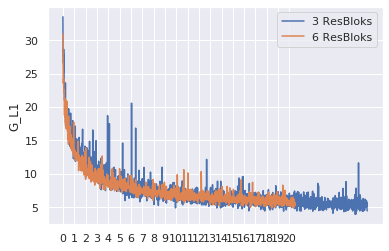

In [134]:
ep_size='auto'
ax = plt.gca()

_plot_L1(df[df.run == 'skip-slim'], ax, label='3 ResBloks', ep_size=ep_size)


_df0 = df[df.run == 'skip-modulate'][:]
_df1 = df[df.run == 'skip-modulate-cont'][:]
_df1.epoch += _df0.epoch.max()-1
_df = pd.concat([_df0, _df1])

_plot_L1(_df,  ax, label='6 ResBloks', ep_size=ep_size)


print('ep_ticks')
_ep_ticks(_df)



save_plt('exp-f1-skips-3-vs-6-res-blocks')

### D vs noD noskip

setting ep_size to  63384.0
setting ep_size to  63380.0
ep_ticks
setting ep_size to  63384.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f1-D-vs-noD-noskip.png


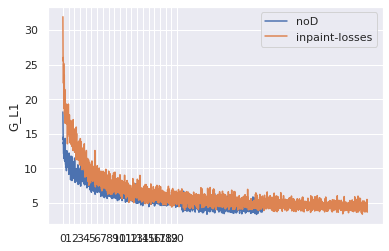

In [135]:
ax = plt.gca()
ep_size = 'auto'
_plot_L1(df[df.run == 'noD'], ax, label='noD', ep_size=ep_size)
_plot_L1(df[df.run == 'inpaint-losses'], ax, label='inpaint-losses', ep_size=ep_size)
# _plot_L1(df[df.run == 'inpaint-losses-style'], ax, label='inpaint-losses-style', ep_size=ep_size, ep_ticks=True)
print('ep_ticks')
_ep_ticks(df[df.run == 'noD'])

save_plt('exp-f1-D-vs-noD-noskip')

### D vs noD skip

setting ep_size to  265900.0
setting ep_size to  266064.0
ep_ticks
setting ep_size to  266064.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f1-D-vs-noD-skip.png


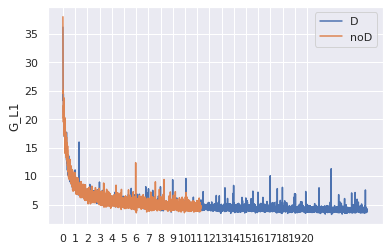

In [136]:
ax = plt.gca()
ep_size = 'auto'
_plot_L1(df[df.run == 'batchnormfix'], ax, label='D', ep_size=ep_size)
_plot_L1(df[df.run == 'morph_loss_old_ds_no_D'], ax, label='noD', ep_size=ep_size)
# _plot_L1(df[df.run == 'inpaint-losses-style'], ax, label='inpaint-losses-style', ep_size=ep_size, ep_ticks=True)

print('ep_ticks')
_ep_ticks(df[df.run == 'morph_loss_old_ds_no_D'])

save_img('exp-f1-D-vs-noD-skip')

### Datasets

setting ep_size to  245000.0
ep_ticks
setting ep_size to  245000.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f1-mlt-vs-synth.png


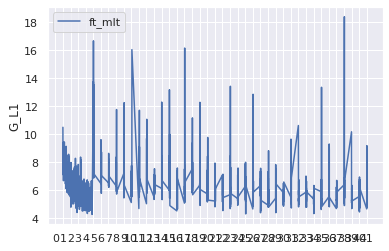

In [142]:
ep_size='auto'
ax = plt.gca()


_df0 = df[df.run == 'synthtrain2'][:]
_df1 = df[df.run == 'ft_mlt'][:]
_df1.epoch += _df0.epoch.max()-1
_df = pd.concat([_df0, _df1])

_plot_L1(_df,  ax, label='ft_mlt')

print('ep_ticks')
_ep_ticks(_df)

save_img('exp-f1-mlt-vs-synth')

## F2

setting ep_size to  266024.0
ep_ticks
setting ep_size to  266024.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f2-noise-vs-self.png


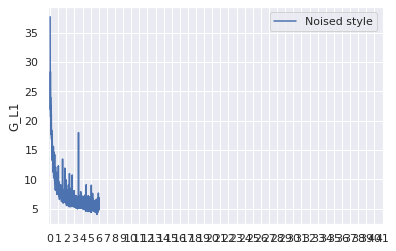

In [138]:
ax = plt.gca()
ep_size = 'auto'
    
_plot_L1(df[df.run == 'noise_style'], ax, label='Noised style', ep_size=ep_size)


print('ep_ticks')
_ep_ticks(df[df.run == 'noise_style'])

save_img('exp-f2-noise-vs-self')

## F3

setting ep_size to  63384.0
setting ep_size to  266000.0
ep_ticks
setting ep_size to  266000.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f3-moph-vs-base.png


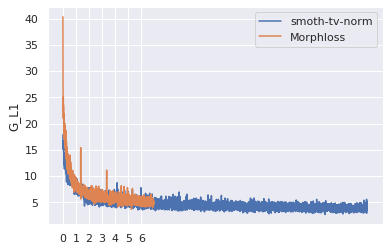

In [139]:
ax = plt.gca()
ep_size = 'auto'



_plot_L1(df[df.run == 'smoth-tv-norm'], ax, label='smoth-tv-norm', ep_size=ep_size)


_df0 = df[df.run == 'morph_loss_old_ds'][:]
_df1 = df[df.run == 'morph_loss_old_ds_cont2'][:]
_df1.epoch += _df0.epoch.max()-1
_df = pd.concat([_df0, _df1])
_plot_L1(_df, ax, label='Morphloss', ep_size=ep_size)


print('ep_ticks')
_ep_ticks(_df)

save_img('exp-f3-moph-vs-base')

setting ep_size to  244980.0
setting ep_size to  245040.0
setting ep_size to  245040.0
setting ep_size to  245040.0
ep_ticks
setting ep_size to  245040.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f3-scheds.png


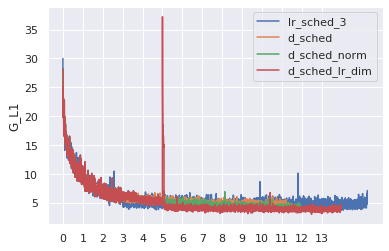

In [140]:
ax = plt.gca()
ep_size = 'auto'

_df = df[df.run == 'lr_sched_3']
_plot_L1(_df, ax, label='lr_sched_3')

_plot_L1(df[df.run == 'd_sched'], ax, label='d_sched')

_df0 = df[df.run == 'd_sched_norm'][:]
_df1 = df[df.run == 'd_sched_norm_cont'][:]
_df1.epoch += _df0.epoch.max()-1
_df = pd.concat([_df0, _df1])
_plot_L1(_df, ax, label='d_sched_norm')


_df0 = df[df.run == 'd_sched']
_df0 = _df[_df.epoch <= 5]
_df1 = df[df.run == 'd_sched_lr_dim'][:]
_df1.epoch += 1
_df = pd.concat([_df0, _df1])
_plot_L1(_df, ax, label='d_sched_lr_dim')





print('ep_ticks')
_ep_ticks(_df)

save_img('exp-f3-scheds')
# _plot_L1(df[df.run == 'inpaint-losses-style'], ax, label='inpaint-losses-style', ep_size=ep_size, ep_ticks=True)

setting ep_size to  245040.0
setting ep_size to  245040.0
setting ep_size to  245040.0
ep_ticks
setting ep_size to  245040.0
Url:  https://ctlab.itmo.ru/~anerinovsky/6269a6ce/tx/plots/exp-f3-scheds-D-real.png


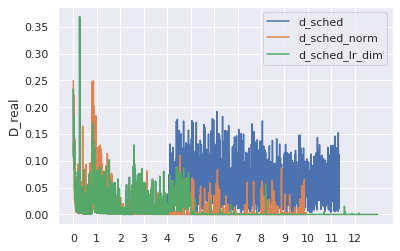

In [143]:
ax = plt.gca()


_plot_D(df[df.run == 'd_sched'], ax, label='d_sched')

_df0 = df[df.run == 'd_sched_norm'][:]
_df1 = df[df.run == 'd_sched_norm_cont'][:]
_df1.epoch += _df0.epoch.min()
_df = pd.concat([_df0, _df1])

_plot_D(_df, ax, label='d_sched_norm')

_df = df[df.run == 'd_sched']
_df = _df[_df.epoch <= 5]
_df0 = df[df.run == 'd_sched_lr_dim']
_df = pd.concat([_df, _df0])
_plot_D(_df, ax, label='d_sched_lr_dim')

print('ep_ticks')
_ep_ticks(_df)

save_img('exp-f3-scheds-D-real')

# Dbg

setting ep_size to  265900.0
setting ep_size to  266004.0
setting ep_size to  245000.0


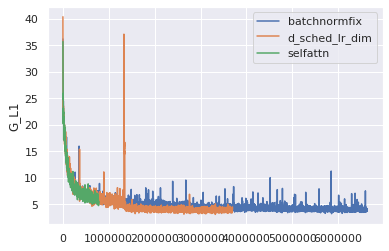

In [148]:
ep_size='auto'
ax = plt.gca()
_plot_L1(df[df.run == 'batchnormfix'], ax, label='batchnormfix', ep_size=ep_size)


_df0 = df[df.run == 'd_sched']
_df0 = _df[_df.epoch <= 5]
_df1 = df[df.run == 'd_sched_lr_dim'][:]
_df1.epoch += 1
_df = pd.concat([_df0, _df1])

_plot_L1(_df, ax, label='d_sched_lr_dim')


_plot_L1(df[df.run == 'selfattn'], ax, label='selfattn', ep_size=ep_size)

## Skip connections

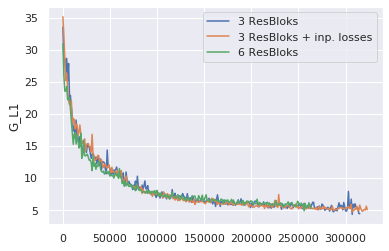

In [205]:
ep_size=10000
ax = plt.gca()
_plot_L1(df[df.run == 'skip-slim'], ax, label='3 ResBloks', ep_size=ep_size)
_plot_L1(df[df.run == 'skip-slim-inp'], ax, label='3 ResBloks + inp. losses', ep_size=ep_size)



_df0 = df[df.run == 'skip-modulate'][:]
_df1 = df[df.run == 'skip-modulate-cont'][:]
_df1.epoch += _df0.epoch.max()
_df = pd.concat([_df0, _df1])

_plot_L1(_df,  ax, label='6 ResBloks', ep_size=ep_size)

save_plt('bg_fail/skips.png')

## Morph Loss

setting ep_size to  265900.0
setting ep_size to  266064.0
setting ep_size to  266000.0


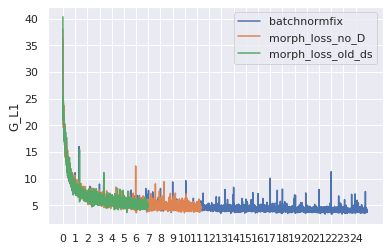

In [206]:
ep_size='auto'
ax = plt.gca()
_plot_L1(df[df.run == 'batchnormfix'], ax, label='batchnormfix', ep_size=ep_size, ep_ticks=True)
_plot_L1(df[df.run == 'morph_loss_old_ds_no_D'], ax, label='morph_loss_no_D', ep_size=ep_size)



_df0 = df[df.run == 'morph_loss_old_ds'][:]
_df1 = df[df.run == 'morph_loss_old_ds_cont2'][:]
_df1.epoch += _df0.epoch.max()-1
_df = pd.concat([_df0, _df1])

_plot_L1(_df,  ax, label='morph_loss_old_ds', ep_size=ep_size)

# save_plt('bg_fail/skips.png')

## Discriminator tuning

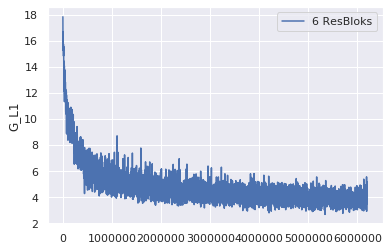

In [147]:
ax = plt.gca()
_df = df[df.run == 'smoth-tv-norm']
_plot_L1(_df,  ax, label='6 ResBloks',  avg_step=1000, ep_size='auto')

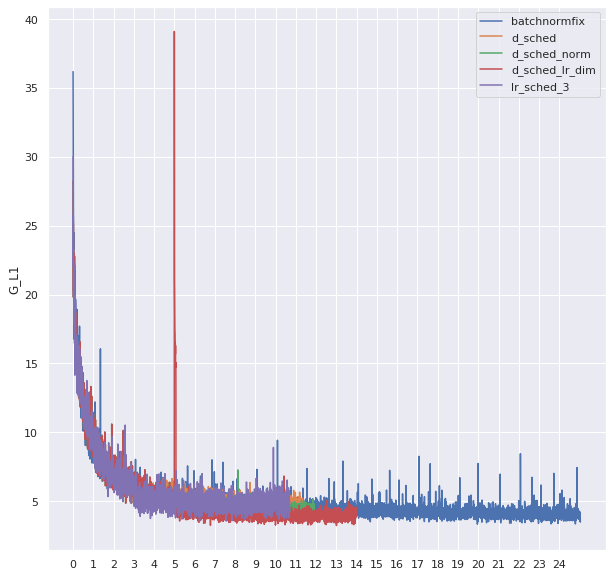

In [45]:
plt.figure(figsize=(10, 10))
ax = plt.gca()

_df = df[df.run == 'batchnormfix']
_plot_L1(_df, ax, label='batchnormfix', ep_ticks=True)

_plot_L1(df[df.run == 'd_sched'], ax, label='d_sched')

_df0 = df[df.run == 'd_sched_norm'][:]
_df1 = df[df.run == 'd_sched_norm_cont'][:]
_df1.epoch += _df0.epoch.max()-1
_df = pd.concat([_df0, _df1])

_plot_L1(_df, ax, label='d_sched_norm')


_df0 = df[df.run == 'd_sched']
_df0 = _df[_df.epoch <= 5]
_df1 = df[df.run == 'd_sched_lr_dim'][:]
_df1.epoch += 1
_df = pd.concat([_df0, _df1])

_plot_L1(_df, ax, label='d_sched_lr_dim')

_df = df[df.run == 'lr_sched_3']
_plot_L1(_df, ax, label='lr_sched_3')

In [195]:
df[df.run == 'batchnormfix'].epoch

280964     1.0
280965     1.0
280966     1.0
280967     1.0
280968     1.0
          ... 
347348    25.0
347349    25.0
347350    25.0
347351    25.0
347352    25.0
Name: epoch, Length: 66389, dtype: float64

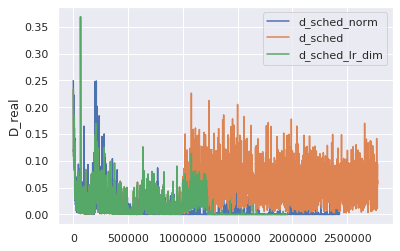

In [210]:
ax = plt.gca()


_df0 = df[df.run == 'd_sched_norm'][:]
_df1 = df[df.run == 'd_sched_norm_cont'][:]
_df1.epoch += _df0.epoch.min()
_df = pd.concat([_df0, _df1])

_plot_D(_df, ax, label='d_sched_norm')


_plot_D(df[df.run == 'd_sched'], ax, label='d_sched')



_df = df[df.run == 'd_sched']
_df = _df[_df.epoch <= 5]
_df0 = df[df.run == 'd_sched_lr_dim']
_df = pd.concat([_df, _df0])
_plot_D(_df, ax, label='d_sched_lr_dim')


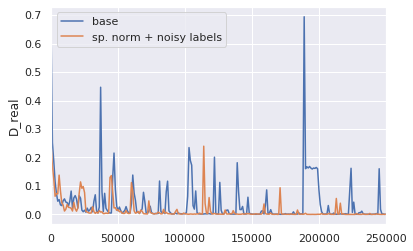

In [109]:
ax = plt.gca()

_plot_D(df[df.run == 'skip-slim-inp'], ax, label='base', ep_size='auto')
_plot_D(df[df.run == 'skip_slim_inp_ds'], ax, label='sp. norm + noisy labels')
# _plot_D(df[df.run == 'batchnormfix'], ax, label='batchnormfix')

plt.xlim([0, 25e4])

save_plt('d_fail/spec-vs-base.png')